In [2]:
import sys, os
sys.path.append('../src')

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import Sigmoid

from tensordict.nn import TensorDictModule, TensorDictSequential

from deepmuonreco.data import InnerTrackSelectionDataset
from deepmuonreco.nn import InnerTrackSelectionTransformer, Normalize
from deepmuonreco.nn.utils import init_params
from deepmuonreco.nn import SelectedBCEWithLogitsLoss

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
from hist import Hist

import hist

import mplhep as hep
import matplotlib as mpl
import uproot
import awkward as ak


%load_ext autoreload
%autoreload 2
import utils

plt.style.use(hep.style.CMS)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model_path = "3e8ca278b78e4a2bafe9faf1"
checkpoint_path = f"../.aim/default/{model_path}/best_model.pt"
data_path = "../data/ttbar2024pu/test.root"

In [4]:
device = torch.device("cpu")
model = utils.load_model(
    checkpoint_path=checkpoint_path,
    device=device,
    dim_model=128,
    dim_feedforward=256,
    num_heads=8,
    num_layers=4
)

test_set = InnerTrackSelectionDataset(path=data_path)
test_loader = DataLoader(
    dataset=test_set,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    collate_fn=InnerTrackSelectionDataset.collate
)
print(f"Test dataset loaded: {len(test_set)}")
print(test_set[0])

Test dataset loaded: 20000
TensorDict(
    fields={
        hit: Tensor(shape=torch.Size([7, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        seg: Tensor(shape=torch.Size([3, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        target: Tensor(shape=torch.Size([199]), device=cpu, dtype=torch.float32, is_shared=False),
        track: Tensor(shape=torch.Size([199, 13]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


In [5]:
tracks, segs, hits = [], [], []
targets, logits, scores = [], [], []
with torch.no_grad():
    model = model.to(device).eval()
    for batch in tqdm(test_loader):
        output = model(batch)

        track_mask = ~batch["pad_masks"]["track"].view(-1)
        seg_mask = ~batch["pad_masks"]["seg"].view(-1)
        hit_mask = ~batch["pad_masks"]["hit"].view(-1)

        track = batch["track"].reshape(-1, batch["track"].shape[-1])[track_mask]
        seg   = batch["seg"].reshape(-1, batch["seg"].shape[-1])[seg_mask]
        hit   = batch["hit"].reshape(-1, batch["hit"].shape[-1])[hit_mask]

        target = batch["target"].reshape(-1)[track_mask]
        logit  = output["logits"].reshape(-1)[track_mask]
        score  = output["score"].reshape(-1)[track_mask]

        tracks.append(track)
        segs.append(seg)
        hits.append(hit)
        targets.append(target)
        logits.append(logit)
        scores.append(score)

tracks  = torch.cat(tracks).numpy()
segs    = torch.cat(segs).numpy()
hits    = torch.cat(hits).numpy()
targets = torch.cat(targets).numpy()
logits  = torch.cat(logits).numpy()
scores  = torch.cat(scores).numpy()

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [15:22<00:00,  5.88s/it]


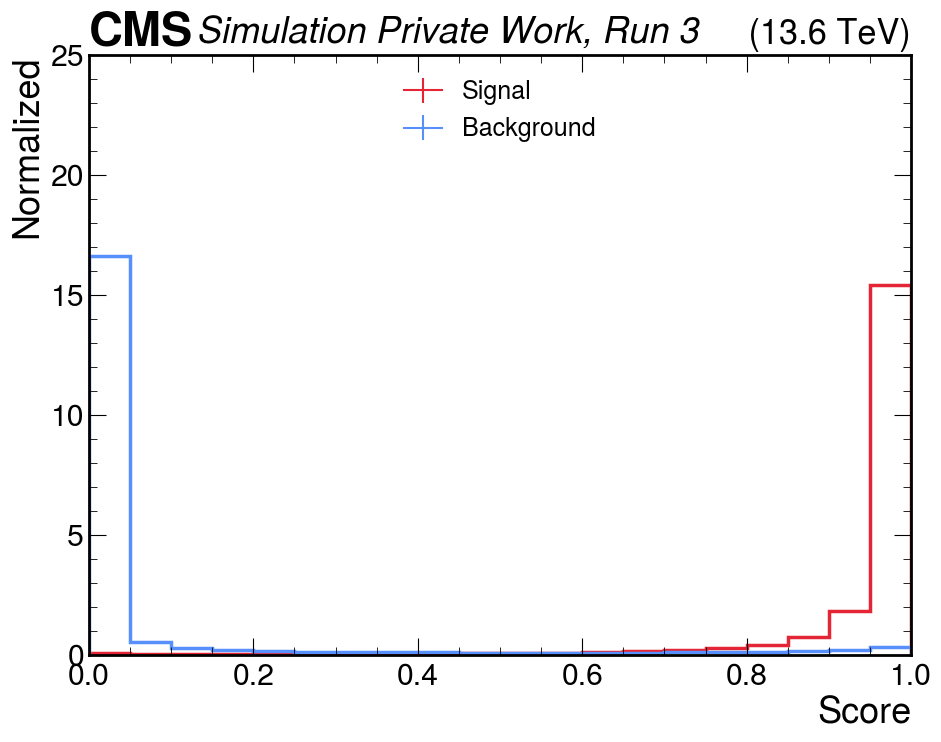

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

fpr, tpr, threshold = roc_curve(targets, scores)
scores_false = scores[targets == 0]
scores_true  = scores[targets == 1]

score_bins = (20, 0, 1)
ax, true_hist = utils.plot_hist_1d(ax=ax, data=scores_true, bins=score_bins,
                                   label="Signal", color='C2', density=True)
ax, false_hist = utils.plot_hist_1d(ax=ax, data=scores_false, bins=score_bins,
                                    xlabel="Score", ylabel="Normalized",
                                    label="Background", color='C0', density=True)
ax.set_ylim(0, 25)
ax.legend(loc='upper center', fontsize=18)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)

plt.tight_layout()
plt.show()

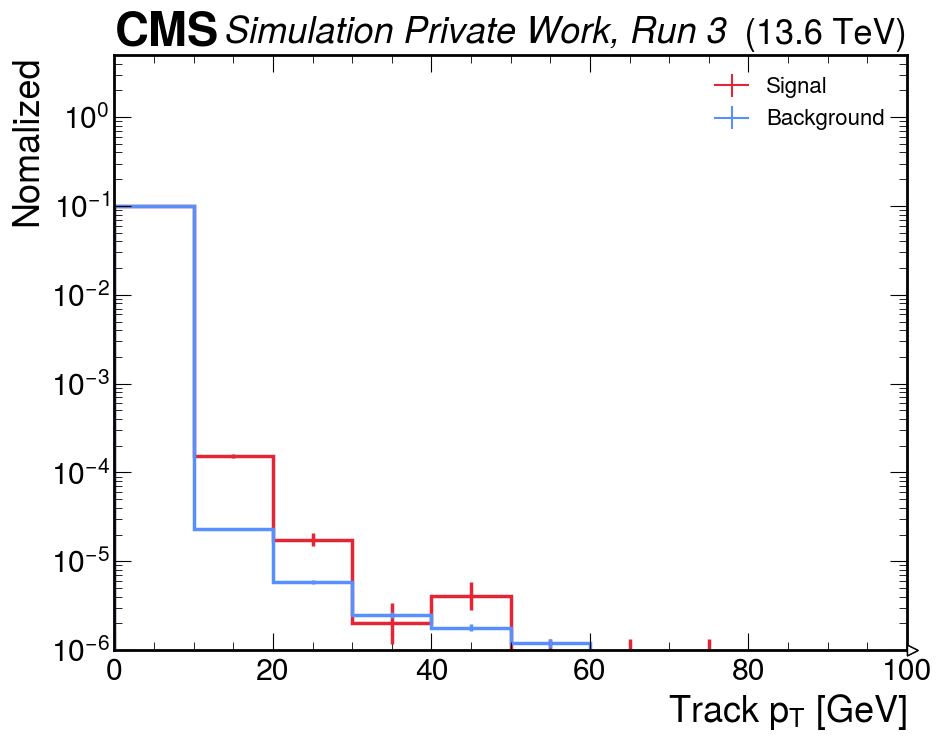

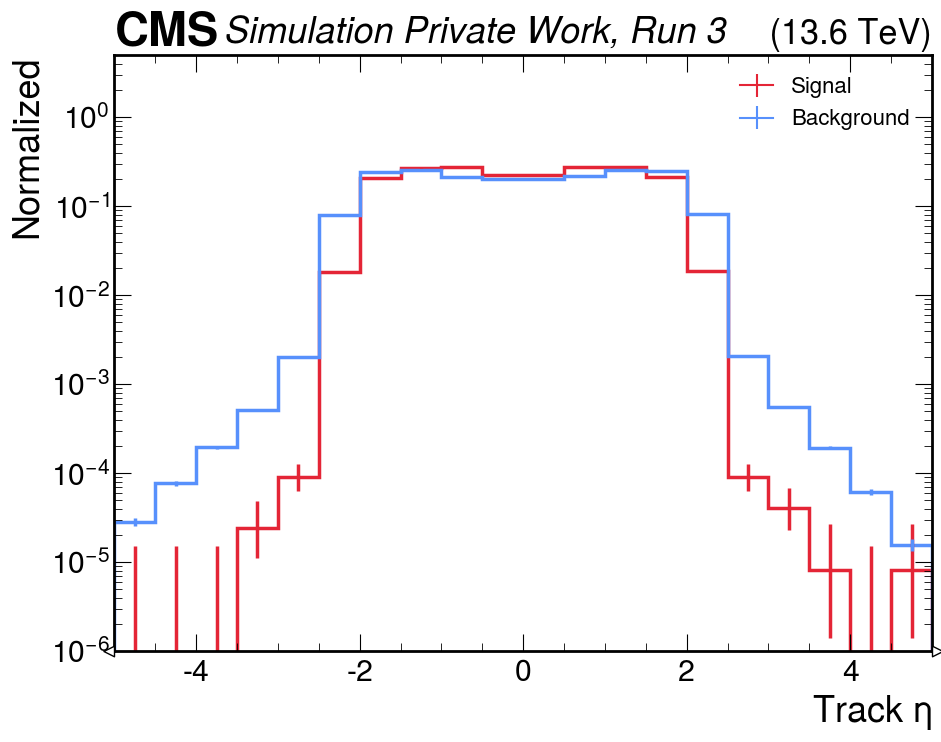

In [7]:
track_pxs = tracks[:, 4]
track_pys = tracks[:, 5]
track_pzs = tracks[:, 6]

track_pts = utils.calc_pt(track_pxs, track_pys)
track_etas = utils.calc_eta(track_pxs, track_pys, track_pzs)


bins_pt = (10, 0, 100)
fig, ax = plt.subplots(figsize=(10, 8))
ax, hist1 = utils.plot_hist_1d(ax=ax, data=track_pts[targets == 1], bins=bins_pt, color='C2', density=True, yerr=True, label=f"Signal")
ax, hist2 = utils.plot_hist_1d(ax=ax, data=track_pts[targets == 0], bins=bins_pt, color='C0', density=True, yerr=True, label=f"Background")
ax.set_xlabel("Track $p_{T}$ [GeV]")
ax.set_ylabel("Nomalized")
ax.set_yscale('log')
ax.set_ylim(1e-6, 5)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
ax.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

bins_eta = (20, -5, 5)
fig, ax = plt.subplots(figsize=(10, 8))
ax, hist1 = utils.plot_hist_1d(ax=ax, data=track_etas[targets == 1], bins=bins_eta, color='C2', density=True, yerr=True, label=f"Signal")
ax, hist2 = utils.plot_hist_1d(ax=ax, data=track_etas[targets == 0], bins=bins_eta, color='C0', density=True, yerr=True, label=f"Background")
ax.set_xlabel(r"Track $\eta$")
ax.set_ylabel("Normalized")
ax.set_yscale('log')
ax.set_ylim(1e-6, 5)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
ax.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

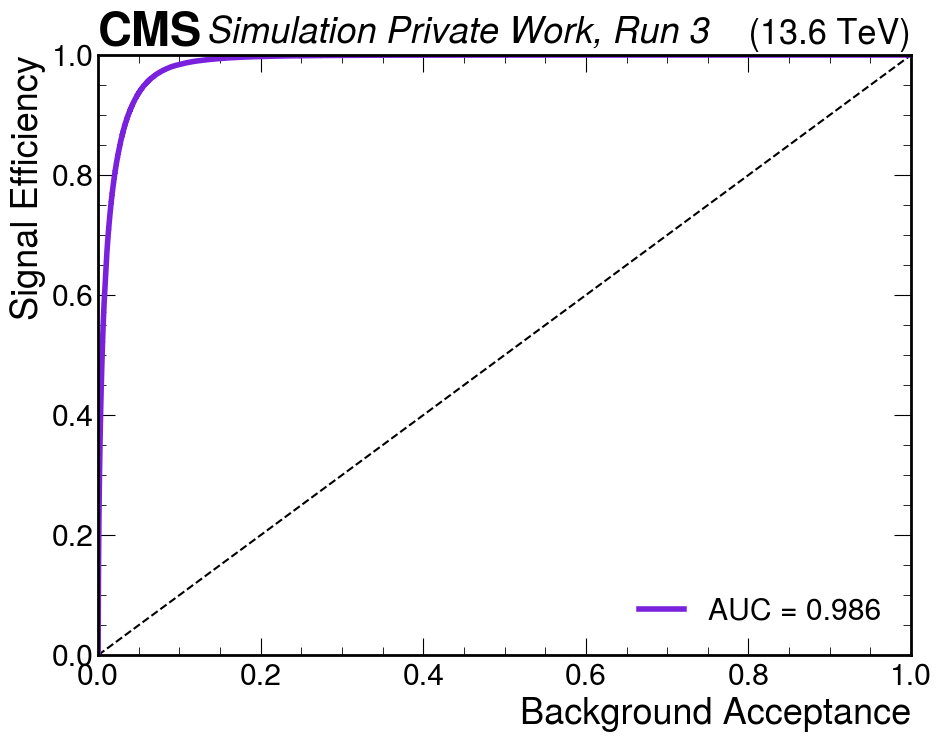

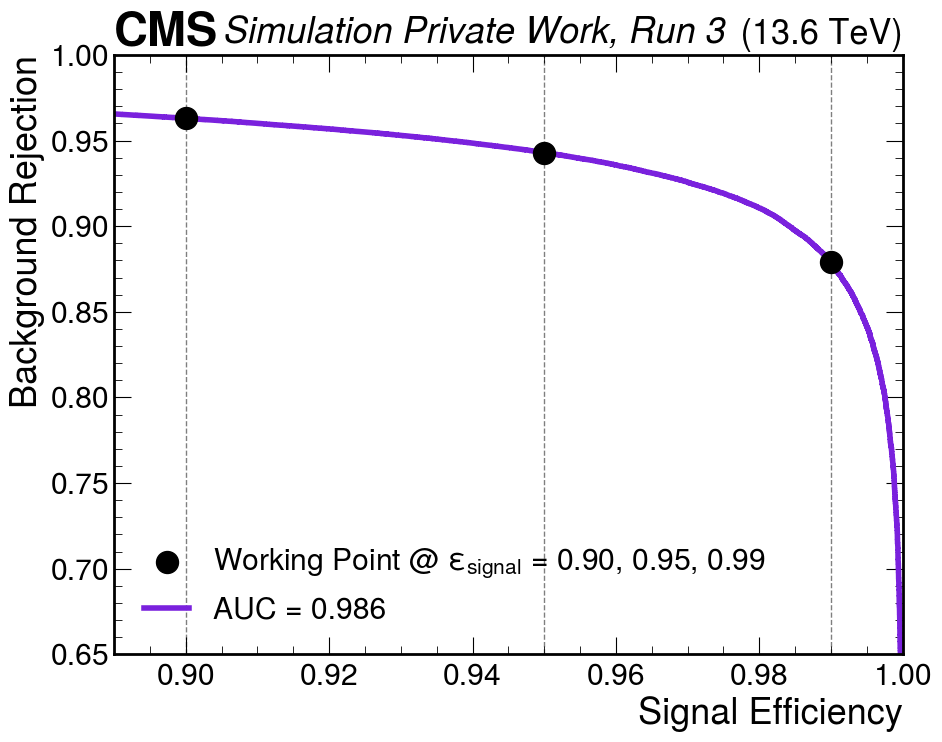

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
fpr, tpr, threshold = roc_curve(targets, scores)

ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.3f}', color='C5', lw=4)

ax.set_xlabel("Background Acceptance")
ax.set_ylabel("Signal Efficiency")
ax.set_xlim(-0, 1)
ax.set_ylim(-0, 1)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 8))
tnr = 1.0 - fpr
ax.scatter(None, None, color='black', zorder=10, s=250, label=r"Working Point @ $\epsilon_{signal}$ = 0.90, 0.95, 0.99")
ax.plot(tpr, tnr, alpha=1.0, color='C5', lw=4, label=f'AUC = {auc(fpr, tpr):.3f}')
tpr_cut = [0.9, 0.95, 0.99]
tnr_cut = [tnr[tpr >= cut].max() if np.any(tpr >= cut) else 0.0 for cut in tpr_cut]
for tpr_c, tnr_c in zip(tpr_cut, tnr_cut):
    ax.axvline(x=tpr_c, color='k', linestyle='--', linewidth=1, alpha=0.5)
    ax.scatter(tpr_c, tnr_c, color='black', zorder=10, s=250)
    #ax.text(tpr_c - 0.009, tnr_c + 0.012, r"$R_{bg}: $"+f"{tnr_c:.2f}", fontsize=20, fontweight='bold', color='black', zorder=6)

hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
ax.set_xlabel("Signal Efficiency")
ax.set_ylabel("Background Rejection")
ax.set_xlim(0.89, 1)
ax.set_ylim(0.65, 1)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [9]:
print(targets)
print(scores)

[0. 0. 0. ... 0. 0. 1.]
[3.5562727e-05 3.4079731e-05 4.0696672e-05 ... 5.1630242e-03 1.0087173e-01
 9.8923433e-01]


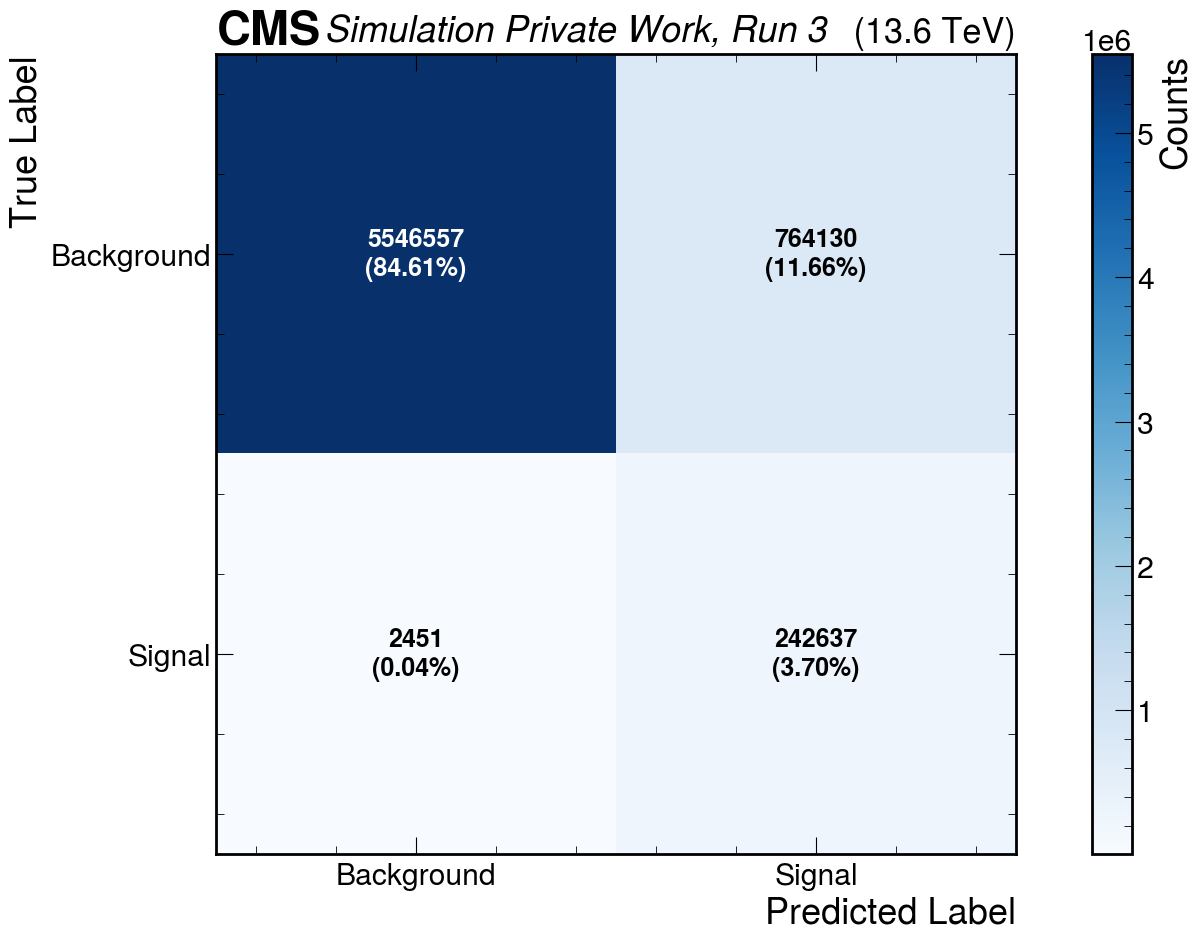

In [10]:
threshold_tpr99 = threshold[tpr > 0.99].max()
cm = confusion_matrix(targets, scores > threshold_tpr99)
cm_normalized = cm.astype('float') / cm.sum()

fig, ax = plt.subplots(figsize=(16, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Counts")

classes = ["Background", "Signal"]
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = f"{cm[i, j]:d}\n({cm_normalized[i, j]*100:.2f}%)"
        ax.text(j, i, text,
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=18, fontweight='bold')

hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)

plt.tight_layout()
plt.show()

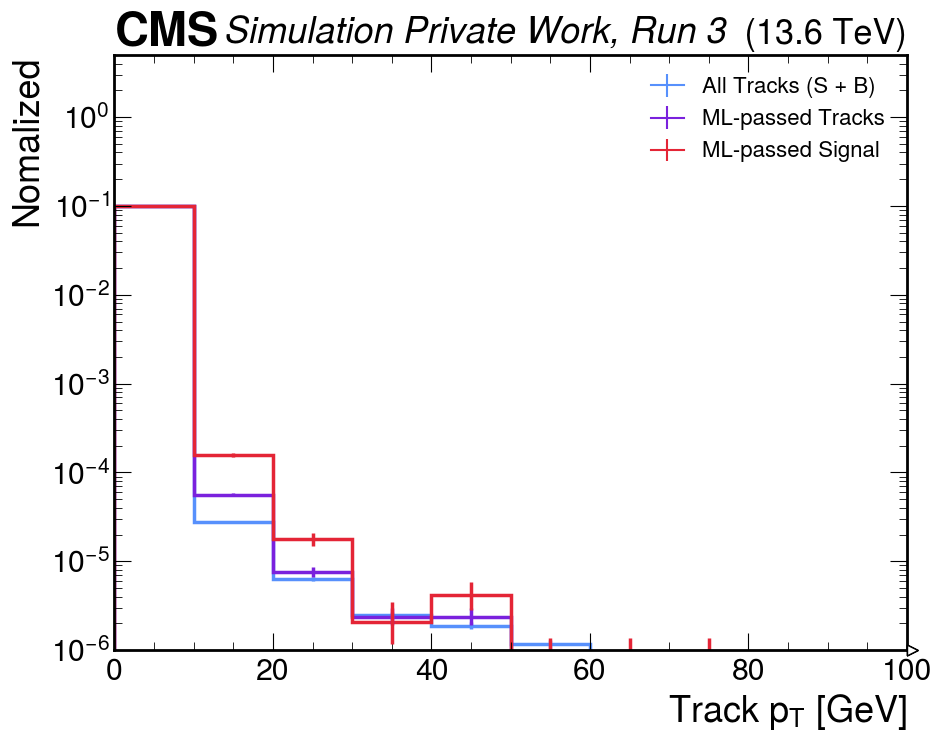

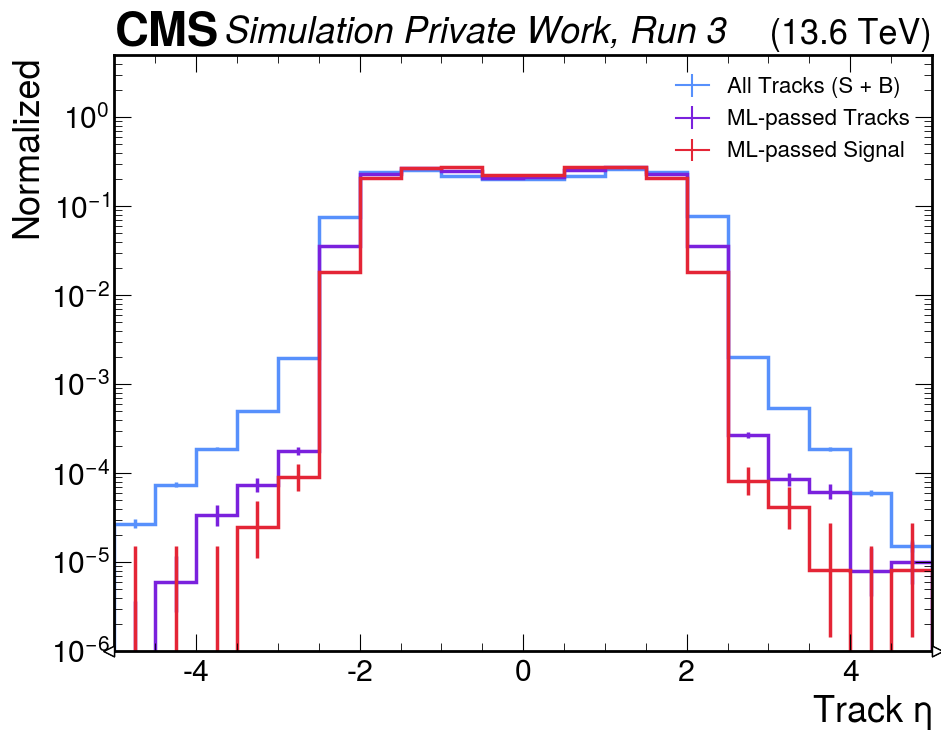

In [11]:
track_pxs = tracks[:, 4]
track_pys = tracks[:, 5]
track_pzs = tracks[:, 6]

track_pts = utils.calc_pt(track_pxs, track_pys)
track_etas = utils.calc_eta(track_pxs, track_pys, track_pzs)

threshold_tpr99 = threshold[tpr > 0.99].max()

bins_pt = (10, 0, 100)
fig, ax = plt.subplots(figsize=(10, 8))
ax, hist1 = utils.plot_hist_1d(ax=ax, data=track_pts, bins=bins_pt, color='C0', density=True, yerr=True,
                               label=f"All Tracks (S + B)")
ax, hist2 = utils.plot_hist_1d(ax=ax, data=track_pts[scores >= threshold_tpr99], bins=bins_pt, color='C5', density=True, yerr=True,
                               label=r"ML-passed Tracks")
ax, hist3 = utils.plot_hist_1d(ax=ax, data=track_pts[(targets == 1) & (scores >= threshold_tpr99)], bins=bins_pt, color='C2', density=True, yerr=True,
                               label=r"ML-passed Signal")
ax.set_xlabel("Track $p_{T}$ [GeV]")
ax.set_ylabel("Nomalized")
ax.set_yscale('log')
ax.set_ylim(1e-6, 5)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
ax.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

bins_eta = (20, -5, 5)
fig, ax = plt.subplots(figsize=(10, 8))
ax, hist1 = utils.plot_hist_1d(ax=ax, data=track_etas, bins=bins_eta, color='C0', density=True, yerr=True,
                               label=f"All Tracks (S + B)")
ax, hist2 = utils.plot_hist_1d(ax=ax, data=track_etas[scores >= threshold_tpr99], bins=bins_eta, color='C5', density=True, yerr=True,
                               label=r"ML-passed Tracks")
ax, hist3 = utils.plot_hist_1d(ax=ax, data=track_etas[(targets == 1)& (scores >= threshold_tpr99)], bins=bins_eta, color='C2', density=True, yerr=True,
                               label=r"ML-passed Signal")
ax.set_xlabel(r"Track $\eta$")
ax.set_ylabel("Normalized")
ax.set_yscale('log')
ax.set_ylim(1e-6, 5)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
ax.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()


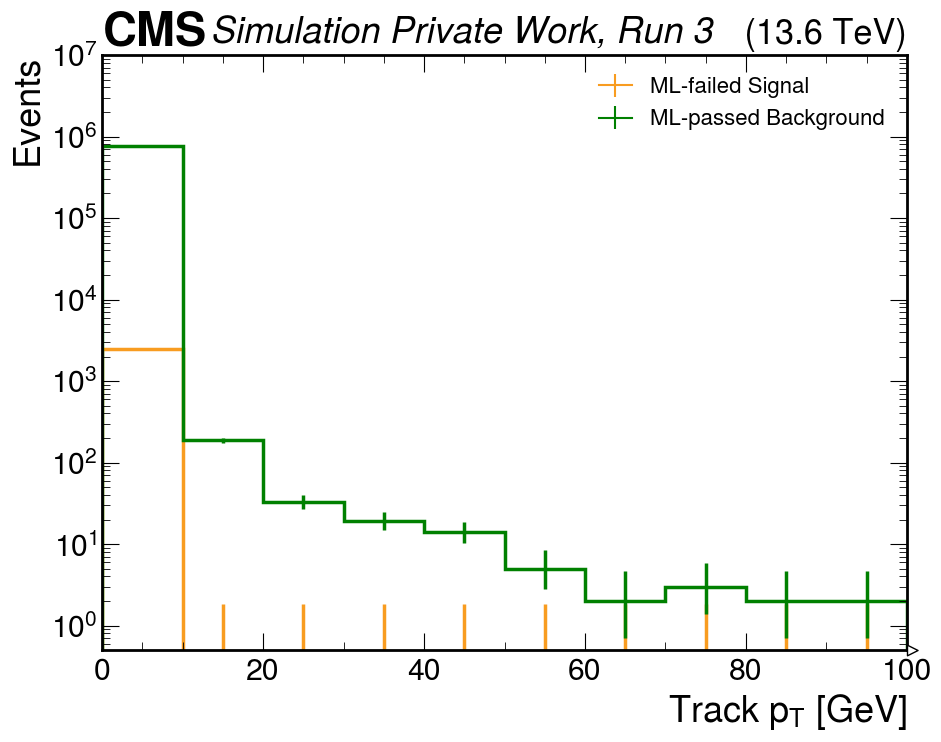

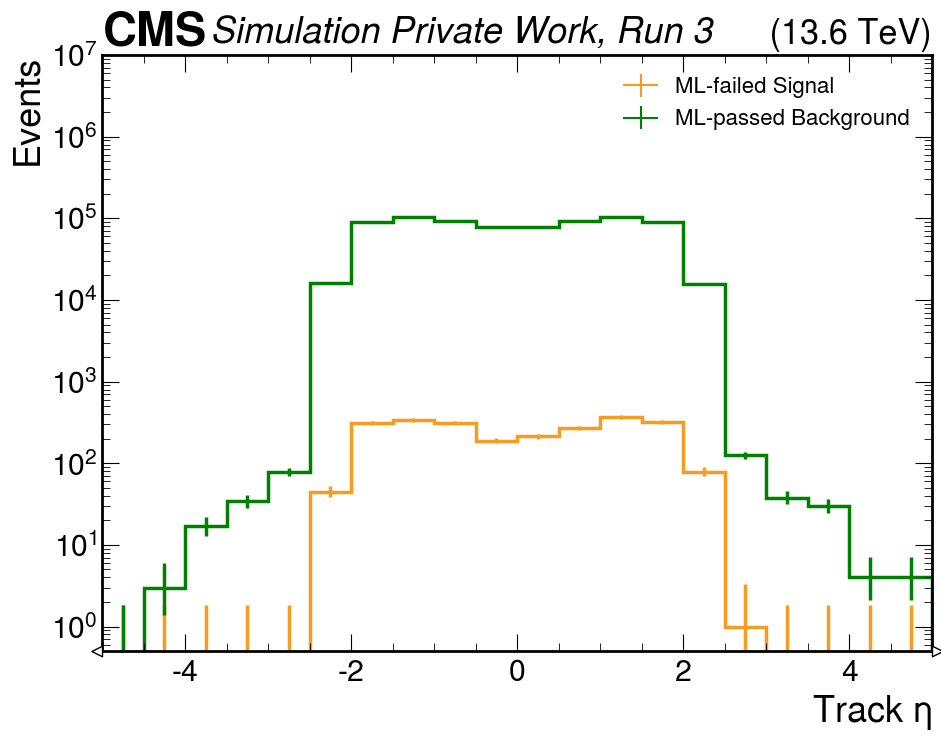

In [12]:
track_pxs = tracks[:, 4]
track_pys = tracks[:, 5]
track_pzs = tracks[:, 6]

track_pts = utils.calc_pt(track_pxs, track_pys)
track_etas = utils.calc_eta(track_pxs, track_pys, track_pzs)

threshold_tpr99 = threshold[tpr > 0.99].max()

bins_pt = (10, 0, 100)
fig, ax = plt.subplots(figsize=(10, 8))
ax, hist1 = utils.plot_hist_1d(ax=ax, data=track_pts[(targets == 1) & (scores < threshold_tpr99)], bins=bins_pt, yerr=True, color="C1",
                               label=r"ML-failed Signal")
ax, hist2 = utils.plot_hist_1d(ax=ax, data=track_pts[(targets == 0) & (scores >= threshold_tpr99)], bins=bins_pt, yerr=True, color="g",
                               label=r"ML-passed Background")
ax.set_xlabel("Track $p_{T}$ [GeV]")
ax.set_ylabel("Events")
ax.set_yscale('log')
ax.set_ylim(0.5, 1e7)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
ax.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

bins_eta = (20, -5, 5)
fig, ax = plt.subplots(figsize=(10, 8))
ax, hist1 = utils.plot_hist_1d(ax=ax, data=track_etas[(targets == 1) & (scores < threshold_tpr99)], bins=bins_eta, yerr=True, color="C1",
                               label=r"ML-failed Signal")
ax, hist2 = utils.plot_hist_1d(ax=ax, data=track_etas[(targets == 0) & (scores >= threshold_tpr99)], bins=bins_eta, yerr=True, color="g",
                               label=r"ML-passed Background")
ax.set_xlabel(r"Track $\eta$")
ax.set_ylabel("Events")
ax.set_yscale('log')
ax.set_ylim(0.5, 1e7)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
ax.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()

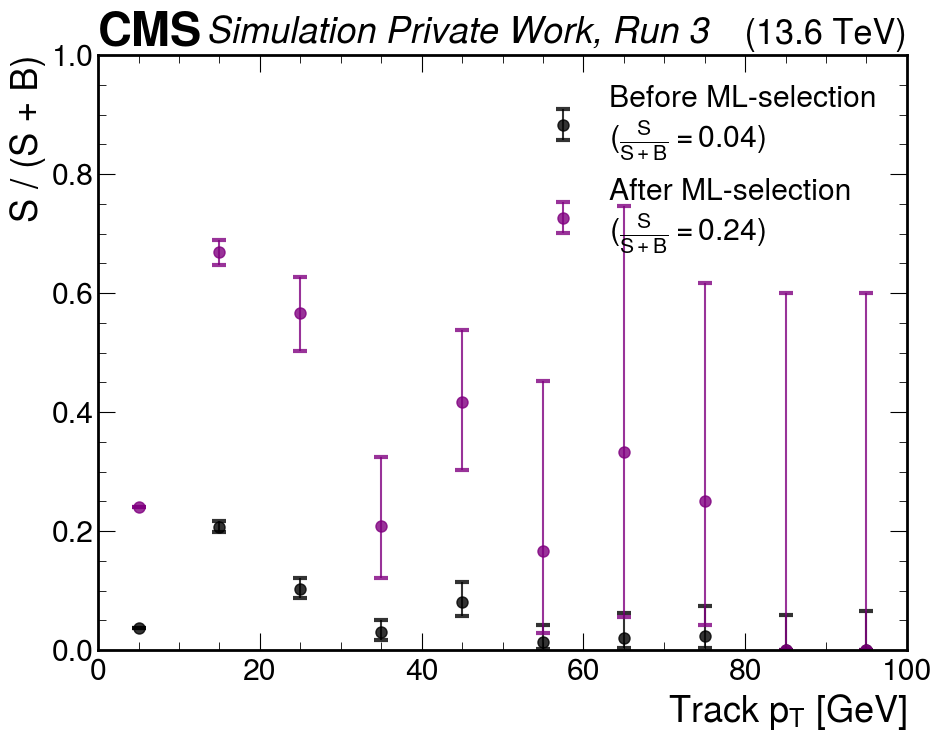

/home/joshin/workspace-gate/DeepMuonReco/notebooks/utils.py:180: RuntimeWarning: invalid value encountered in divide
  eff = hist_num.to_numpy()[0] / hist_denom.to_numpy()[0]


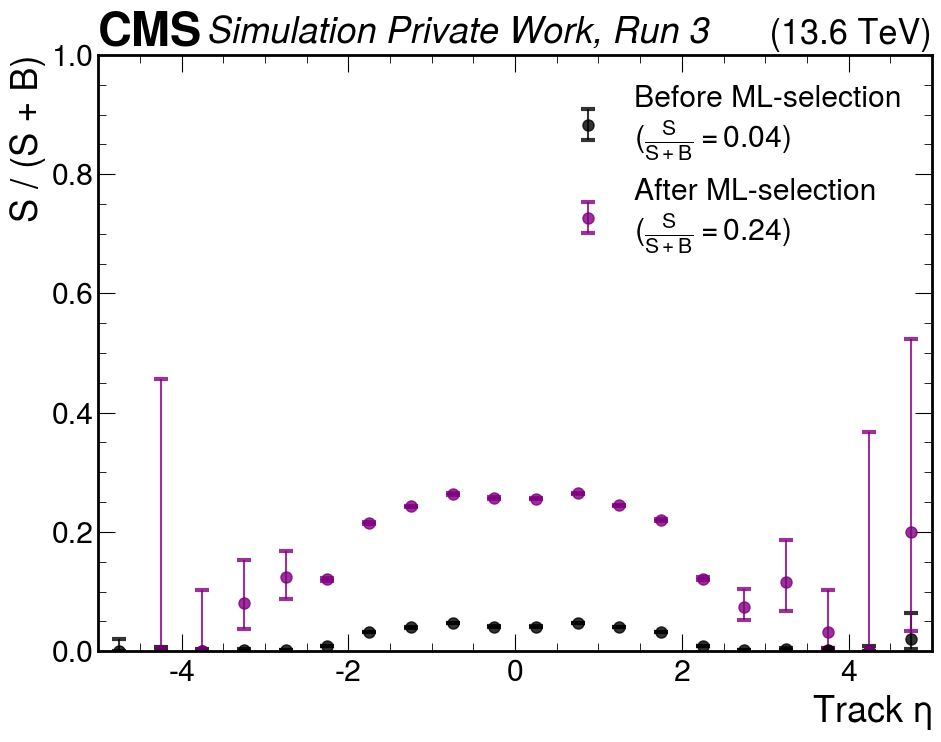

In [13]:
track_pxs = tracks[:, 4]
track_pys = tracks[:, 5]
track_pzs = tracks[:, 6]

track_pts = utils.calc_pt(track_pxs, track_pys)
track_etas = utils.calc_eta(track_pxs, track_pys, track_pzs)

threshold_tpr99 = threshold[tpr > 0.99].max()
is_muon = targets == 1
is_selected = scores >= threshold_tpr99

bins_pt = (10, 0, 100)
fig, ax = plt.subplots(figsize=(10, 8))
ax, eff1 = utils.plot_efficiency_1d(ax=ax, num=track_pts[is_muon], denom=track_pts, bins=bins_pt,
                                    label=f"Before ML-selection\n" + fr"($\frac{{S}}{{S+B}}=${len(track_pts[is_muon]) / len(track_pts):.2f})", color='black')
ax, eff2 = utils.plot_efficiency_1d(ax=ax, num=track_pts[is_muon & is_selected], denom=track_pts[is_selected], bins=bins_pt,
                                    label=f"After ML-selection\n" + fr"($\frac{{S}}{{S+B}}=${len(track_pts[is_muon & is_selected]) / len(track_pts[is_selected]):.2f})", color='purple')

ax.set_xlabel(r"Track $p_{T}$ [GeV]")
ax.set_ylabel(r"S / (S + B)")
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
plt.tight_layout()
plt.show()

bins_eta = (20, -5, 5)
fig, ax = plt.subplots(figsize=(10, 8))
ax, eff1 = utils.plot_efficiency_1d(ax=ax, num=track_etas[is_muon], denom=track_etas, bins=bins_eta,
                                    label=f"Before ML-selection\n" + fr"($\frac{{S}}{{S+B}}=${len(track_etas[is_muon]) / len(track_etas):.2f})", color='black')
ax, eff2 = utils.plot_efficiency_1d(ax=ax, num=track_etas[is_muon & is_selected], denom=track_etas[is_selected], bins=bins_eta,
                                    label=f"After ML-selection\n" + fr"($\frac{{S}}{{S+B}}=${len(track_etas[is_muon & is_selected]) / len(track_etas[is_selected]):.2f})", color='purple')
ax.set_xlabel(r"Track $\eta$")
ax.set_ylabel(r"S / (S + B)")
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
plt.tight_layout()
plt.show()

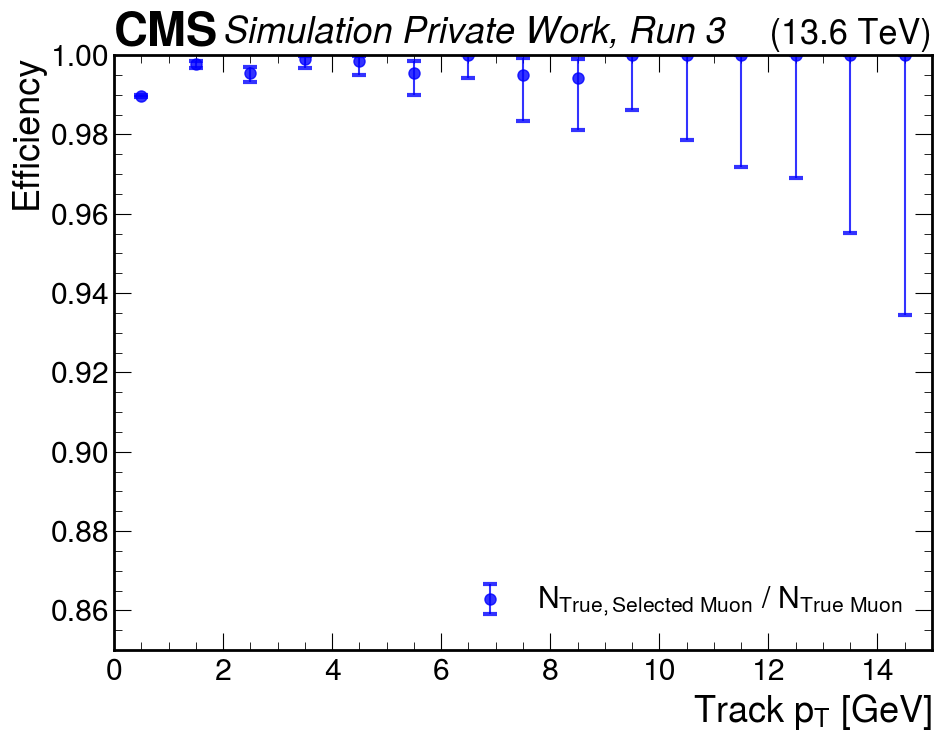

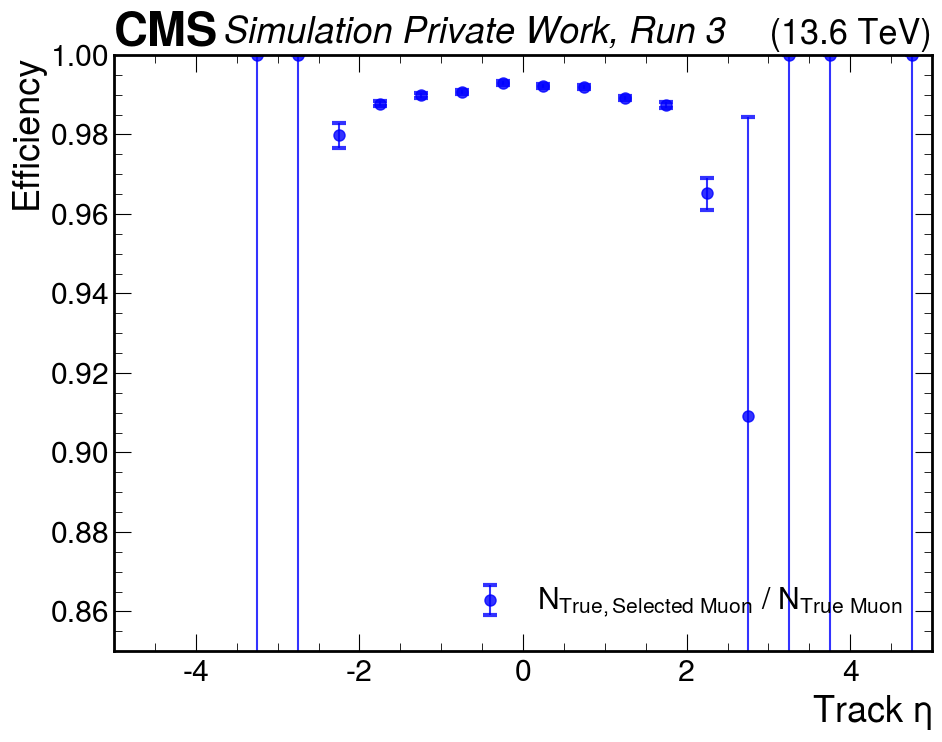

In [29]:
# pt efficiency
bins_pt = (15, 0, 15)
fig, ax = plt.subplots(figsize=(10, 8))
ax, eff_pt = utils.plot_efficiency_1d(
    ax=ax,
    num=track_pts[is_muon & is_selected],   # numerator: selected true muons
    denom=track_pts[is_muon],               # denominator: all true muons
    bins=bins_pt,
    label=r"$N_{True, Selected\ Muon}$ / $N_{True\ Muon}$",
    color='blue'
)

ax.set_xlabel(r"Track $p_{T}$ [GeV]")
ax.set_ylabel("Efficiency")
ax.set_ylim(0.85, 1.0)
ax.legend(loc='lower right')
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
plt.tight_layout()
plt.show()

# eta efficiency
bins_eta = (20, -5, 5)
fig, ax = plt.subplots(figsize=(10, 8))
ax, eff_eta = utils.plot_efficiency_1d(
    ax=ax,
    num=track_etas[is_muon & is_selected],  # numerator: selected true muons
    denom=track_etas[is_muon],              # denominator: all true muons
    bins=bins_eta,
    label=r"$N_{True, Selected\ Muon}$ / $N_{True\ Muon}$",
    color='blue'
)

ax.set_xlabel(r"Track $\eta$")
ax.set_ylabel("Efficiency")
ax.set_ylim(0.85, 1.0)
ax.legend(loc='lower right')
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
plt.tight_layout()
plt.show()

In [14]:
single_loader = DataLoader(
    dataset=test_set,
    batch_size=1,
    shuffle=False,
    drop_last=True,
    collate_fn=InnerTrackSelectionDataset.collate,
)

n_tracks, n_true_muons = [], []
n_pred_muons, n_pred_true_muons = [], []
with torch.no_grad():
    model = model.to(device).eval()
    for i, batch in tqdm(enumerate(single_loader)):
        target = batch["target"][0]
        output = model(batch)
        score = output["score"][0]

        pred_muon = (score > threshold_tpr99)
        true_muon = (target == 1)

        n_track          = len(target)
        n_true_muon      = len(target[true_muon])
        n_pred_muon      = len(score[pred_muon])
        n_pred_true_muon = len(score[pred_muon & true_muon])
        
        n_tracks.append(n_track)
        n_true_muons.append(n_true_muon)
        n_pred_muons.append(n_pred_muon)
        n_pred_true_muons.append(n_pred_true_muon)
        #if i == 10000:
        #    break


13it [00:00, 61.30it/s]

20000it [04:53, 68.06it/s]


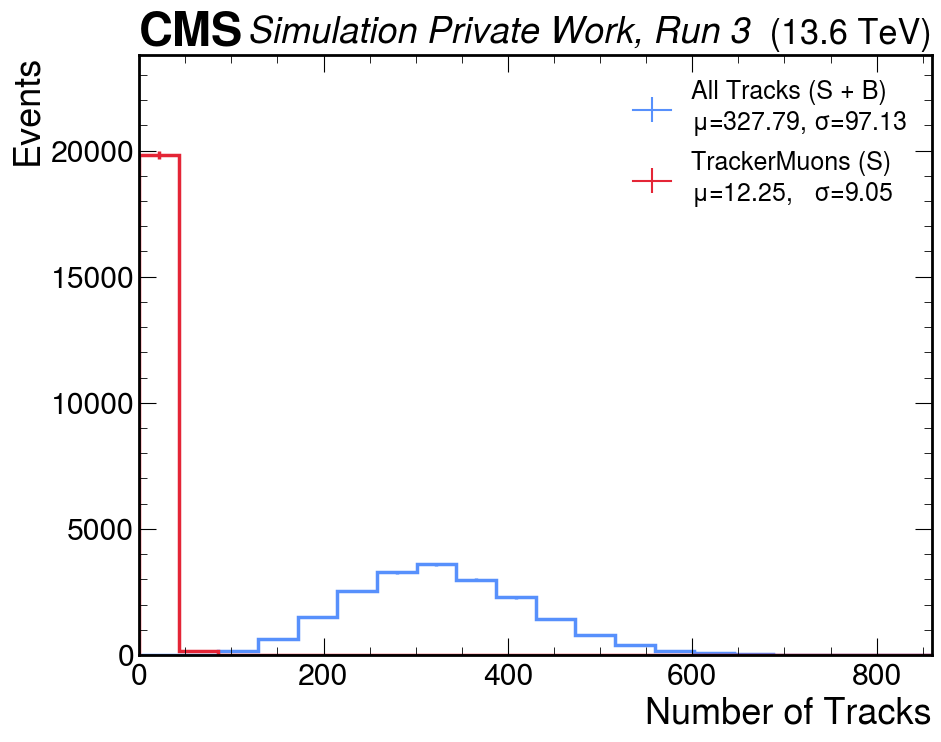

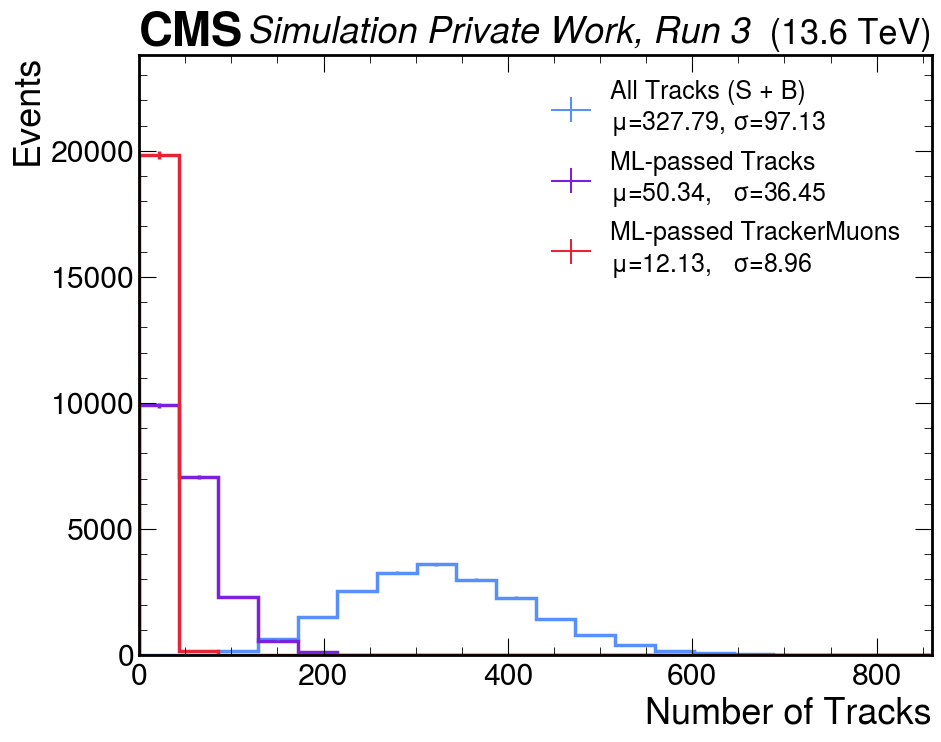

In [15]:
event_bins = (20, 0, 860)
fig, ax = plt.subplots(figsize=(10, 8))
ax, n_track_hist = utils.plot_hist_1d(ax=ax, data=np.array(n_tracks), bins=event_bins,
                                      label="All Tracks (S + B)\n" + fr"$\mu$={np.mean(n_tracks):.2f}, $\sigma$={np.std(n_tracks):.2f}",
                                      color='C0', density=False)
ax, n_true_muon_hist =  utils.plot_hist_1d(ax=ax, data=np.array(n_true_muons), bins=event_bins,
                                      label="TrackerMuons (S) \n" + fr"$\mu$={np.mean(n_true_muons):.2f},   $\sigma$={np.std(n_true_muons):.2f}",
                                      color='C2', density=False)
ax.set_xlabel("Number of Tracks")
ax.set_ylabel("Events")
ax.set_ylim(0, max(n_track_hist.values().max(), n_true_muon_hist.values().max()) * 1.2)
ax.legend(loc='upper right', fontsize=18)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 8))
ax, n_track_hist = utils.plot_hist_1d(ax=ax, data=np.array(n_tracks), bins=event_bins,
                                      label="All Tracks (S + B)\n" + fr"$\mu$={np.mean(n_tracks):.2f}, $\sigma$={np.std(n_tracks):.2f}",
                                      color='C0', density=False)
ax, n_pred_muon_hist =  utils.plot_hist_1d(ax=ax, data=np.array(n_pred_muons), bins=event_bins,
                                      label=r"ML-passed Tracks" + "\n" + fr"$\mu$={np.mean(n_pred_muons):.2f},   $\sigma$={np.std(n_pred_muons):.2f}",
                                      color='C5', density=False)
ax, n_pred_true_muon_hist =  utils.plot_hist_1d(ax=ax, data=np.array(n_pred_true_muons), bins=event_bins,
                                      label="ML-passed TrackerMuons \n" + fr"$\mu$={np.mean(n_pred_true_muons):.2f},   $\sigma$={np.std(n_pred_true_muons):.2f}",
                                      color='C2', density=False)
ax.set_xlabel("Number of Tracks")
ax.set_ylabel("Events")
ax.set_ylim(0, max(n_track_hist.values().max(), n_pred_muon_hist.values().max(), n_pred_true_muon_hist.values().max()) * 1.2)
ax.legend(loc='upper right', fontsize=18)
hep.cms.label("Private Work, Run 3", ax=ax, data=False, com=13.6)
plt.tight_layout()
plt.show()